# OCR License Plate Recognition

## 1. Installing & Importing dependencies

In [1]:
!conda install pytorch torchvision torchaudio -c pytorch -y
!conda install -c conda-forge easyocr -y
!pip install typing-extensions==4.8.0
!conda install pandas numpy matplotlib opencv imutils sqlite -y
!conda install -c conda-forge qrcode -y
!conda install -c conda-forge pillow
!conda install -c conda-forge pyzbar -y

Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-64
Solving environment: done

# All requested packages already installed.

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/lucianobendi/anaconda3/envs/myenv

  added / updated specs:
    - easyocr


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main/osx-64::certifi-2024.2.2-py~ --> conda-forge/noarch::certifi-2024.2.2-pyhd8ed1ab_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from pyzbar.pyzbar import decode
import cv2
import easyocr
import imutils
import sqlite3
import datetime
import qrcode

## 2. Linking webcame image

[ WARN:0@78.353] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


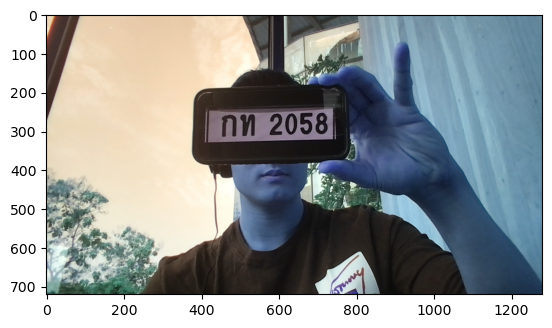

In [2]:
# Connecting camera
cap = cv2.VideoCapture(0)
# Capturing a frame from the camera
ret, frame = cap.read()
# Visualizing frame data
plt.imshow(frame)

## 3. Using Openvc to crop license plate out of image

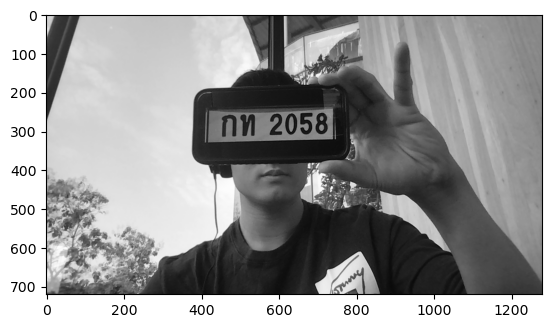

In [3]:
# Converting image to greyscale
grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(grey, cv2.COLOR_BGR2RGB))

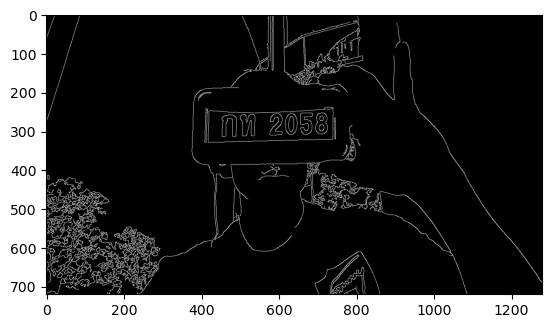

In [4]:
# Noise reduction
noise = cv2.bilateralFilter(grey, 11, 17, 17)
# Edge detection
edge = cv2.Canny(noise, 30, 200)

# plotting image
plt.imshow(cv2.cvtColor(edge, cv2.COLOR_BGR2RGB))

In [5]:
# Finding contours and applying mask
keypoints = cv2.findContours(edge.copy(),cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [6]:
# Approximating polygons (License plate shape)
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
location

array([[[742, 241]],

       [[423, 248]],

       [[418, 329]],

       [[738, 322]]], dtype=int32)

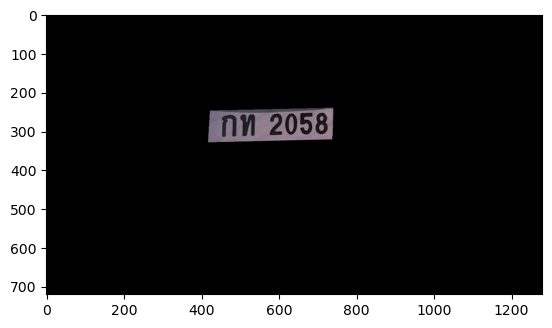

In [7]:
# Masking license plate cutout

# Creating a mask in the shape of the image
mask = np.zeros(grey.shape, np.uint8)
# Drawing contour cutout within the mask
License_img = cv2.drawContours(mask, [location], 0, 255, -1)
# Overlaying mask over the original image
License_img = cv2.bitwise_and(frame, frame, mask=mask)

# Plotting licenseplate image
plt.imshow(cv2.cvtColor(License_img, cv2.COLOR_BGR2RGB))

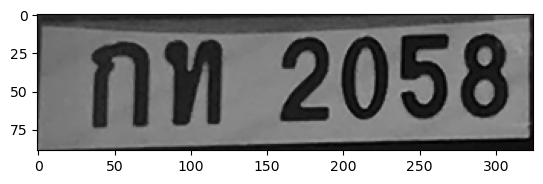

In [8]:
# Cropping out the license plate 

# Searching for sections where image is not black
(x,y) = np.where(mask==255)
# Grabbing the Min x & y values
(x1, y1) = (np.min(x), np.min(y))
# Grabbing the Max x & y values
(x2, y2) = (np.max(x), np.max(y))
# identifying image range
Cropped_license = grey[x1:x2+1, y1:y2+1]

# Plotting new image range
plt.imshow(cv2.cvtColor(Cropped_license, cv2.COLOR_BGR2RGB))

## 4. Linking license plate image to EasyOCR

In [9]:
# Idetifying languages for EasyOCR to detect & read
reader = easyocr.Reader (['en', 'th'])
# Pulling data from image
result = reader.readtext (Cropped_license)
# Extracting license plate string from EasyOCR output
text = result[0][1]
# Printing result to check
text

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


'กท 2058'

## 5. Creating database to store license plate data


In [10]:
# Connecting to database
connection = sqlite3.connect('license_plates_th.csv')
# Linking a cursor associated with this connection
cursor = connection.cursor()

In [11]:
# Creating table / checking if a table with the following format exists
sql_command = """CREATE TABLE IF NOT EXISTS sample (
entry_time CURRENT_TIMESTAMP,
license_plate VARCHAR(30),
payment BINARY(1))"""
cursor.execute(sql_command)

In [12]:
# Allocating data that will be stored in each row
date = datetime.datetime.now()
LP = text
Entry = 0

In [13]:
# Formatting row data in column order
Licenses = [[date, LP, Entry]]

In [14]:
# Entering/ updating data in the table
for i in range(len(Licenses)):
    entry_time = Licenses[i][0]
    license_plate = Licenses[i][1]
    payment = Licenses[i][2]
    cursor.execute("INSERT INTO sample VALUES (?, ?, ?)", (entry_time, license_plate, payment))

In [15]:
# Saving changes
connection.commit()

In [16]:
# Checking updated database
cursor.execute('SELECT * FROM sample')
results = cursor.fetchall()
for i in results:
    print(i)

('2024-02-11 16:37:48.979500', 'กท 2058', 0)
('2024-02-11 19:46:40.396794', 'กท 2058', 0)
('2024-02-12 16:00:56.472522', 'กท 2058', 0)


In [17]:
# Closing connection
connection.close()

## 7. Generating QR code linked to license plate number (As user ID)

In [22]:
# Defining data to be stored in QR code
License = text
Datetime = date.strftime("%Y-%m-%d %H:%M:%S")

def generate_qr_code(user_id):
    # Create a QR code instance
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        border=4,
    )

    # Add data to the QR code
    qr.add_data(f"user_id:{user_id}")
    qr.make(fit=True)

    # Create an image from the QR code data
    img = qr.make_image(fill_color="black", back_color="white")

    # Save the QR code image
    img.save(f"qr_code_user_{user_id}.png")
    # Show QR code
    img.show()

# Run code only if the script is the main program being run (avoids unnecessary code running when exporting to other scripts)
if __name__ == "__main__":
    # Defining data to ecode in the QR
    user_id = Datetime + ", " + License
    # Running the function to create a QR code using "user_id" data
    generate_qr_code(user_id)
    # Print cofirmation of QR code creation
    print(f"QR code for User ID {user_id} generated.")

QR code for User ID 2024-02-12 16:00:56, กท 2058 generated.


## 8. Reading QR code

[ WARN:0@540.941] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


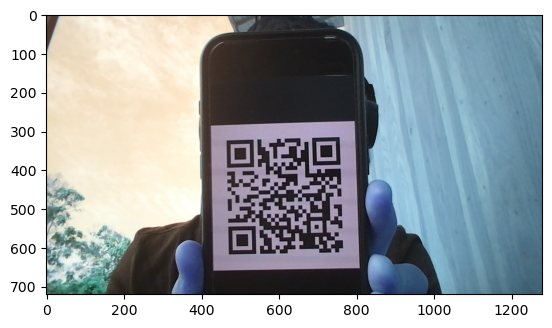

In [23]:
# Connecting camera
cap = cv2.VideoCapture(0)
# getting a frame from the capture device
ret, QR = cap.read()
# Visualizing frame data
plt.imshow(QR)

In [24]:
def read_qr_code(QR):
    # Read the QR code image
    img = cv2.imread(QR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Use pyzbar to decode the QR code
    decoded_objects = decode(gray)

    # Extract user ID from the decoded data
    user_id = None
    for obj in decoded_objects:
        if obj.type == 'QRCODE':
            data = obj.data.decode('utf-8')
            user_id_line = next((line for line in data.split('\n') if 'user_id' in line), None)
            if user_id_line:
                user_id = user_id_line.split(':')[1].strip()

    return user_id
# Print extracted data
print (user_id)

2024-02-12 16:00:56, กท 2058


## 9. Calculating time passed

In [29]:
# Extracting datetime from QR code strong above
from datetime import datetime

# Defining the format of the datetime
datetime_format = "%Y-%m-%d %H:%M:%S"

# Determining the datetime range
datetime_str = user_id[:19]

# Chaging the datetime string into a datetime object
formatted_datetime = datetime.strptime(datetime_str, datetime_format)

# Print formatted datetime
formatted_datetime

datetime.datetime(2024, 2, 12, 16, 0, 56)

In [30]:
# Get the current time
current_time = datetime.now()

# Calculate the time difference
time_difference = current_time - formatted_datetime

# Print the time difference in a specific format
print(f"Time difference: {time_difference}")

Time difference: 0:16:42.719361
